In [1]:
# prompt: drive mout

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:



import os
os.chdir('/content/drive/MyDrive/pneumonia_detection_epics')  # Change this path to your dataset folder

In [3]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")
    return np.array(data, dtype=object)


In [ ]:
train = get_data("chest_xray/chest_xray/train")
test = get_data("chest_xray/chest_xray/test")
val = get_data("chest_xray/chest_xray/val")

In [ ]:
pneumonia = os.listdir("chest_xray/chest_xray/train/PNEUMONIA")
penomina_dir = "chest_xray/chest_xray/train/PNEUMONIA"

In [ ]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [ ]:
normal = os.listdir("chest_xray/chest_xray/train/NORMAL")
normal_dir = "chest_xray/chest_xray/train/NORMAL"

In [ ]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

<Axes: xlabel='count'>

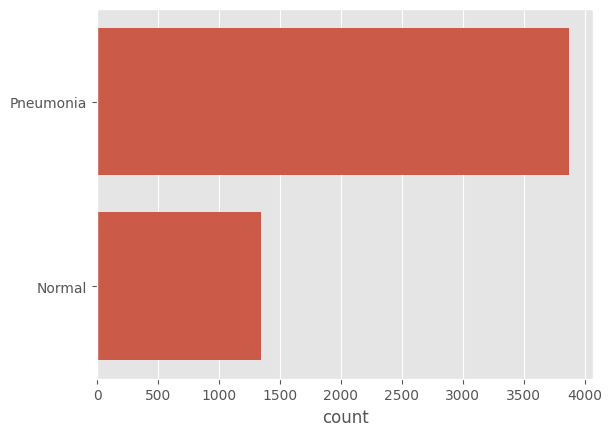

In [ ]:

listx = []
for i in train:
    if(i[1] == 0):
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.countplot(listx)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1. / 255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(224,224),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(224,224),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(224,224),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [ ]:
class_labels = train_generator.class_indices

In [ ]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:

class_name = {value:key for (key, value) in class_labels.items()}

In [ ]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, GlobalAveragePooling2D, Multiply
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, Reshape
from tensorflow.keras.layers import BatchNormalization



In [ ]:
# Define SENet Block
class SEBlock(tf.keras.layers.Layer):
    def __init__(self, ratio=16, **kwargs):
        super(SEBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.squeeze_pool = GlobalAveragePooling2D()
        self.dense_1 = Dense(channels // self.ratio, activation='relu')
        self.dense_2 = Dense(channels, activation='sigmoid')
        self.reshape = Reshape((1, 1, channels))

    def call(self, inputs):
        channels = inputs.shape[-1]
        squeeze = self.squeeze_pool(inputs)
        excitation = self.dense_1(squeeze)
        excitation = self.dense_2(excitation)
        excitation = self.reshape(excitation)
        scale = Multiply()([inputs, excitation])
        return scale

# Create SENet model
def create_senet_model(input_shape=(128, 128, 3), num_classes=2):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = SEBlock()(x)  # Apply SE block
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create model
model = create_senet_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,591,202 (78.55 MB)

 Trainable params: 20,588,130 (78.54 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [ ]:

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Set learning rate to 0.0001
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Define callbacks
callbacks = [
    ModelCheckpoint('senet_model.keras', save_best_only=True, save_weights_only=False),
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator,
    callbacks=callbacks
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 530ms/step - accuracy: 0.9259 - loss: 0.1970 - val_accuracy: 0.5000 - val_loss: 6.1455 - learning_rate: 5.0000e-05
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 551ms/step - accuracy: 0.9238 - loss: 0.1918 - val_accuracy: 0.8750 - val_loss: 0.3777 - learning_rate: 5.0000e-05
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 530ms/step - accuracy: 0.9294 - loss: 0.1867 - val_accuracy: 0.5000 - val_loss: 5.9058 - learning_rate: 5.0000e-05
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 529ms/step - accuracy: 0.9379 - loss: 0.1592 - val_accuracy: 0.5000 - val_loss: 5.1278 - learning_rate: 5.0000e-05
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 548ms/step - accuracy: 0.9400 - loss: 0.1586 - val_accuracy: 0.8750 - val_loss: 0.2474 - learning_rate: 5.0000e-05


In [ ]:
# Evaluate the model on validation and test sets
model_val_eval = model.evaluate(valid_generator)
model_test_eval = model.evaluate(test_generator)

# Print the results
print(f"Validation Loss: {model_val_eval[0]}")
print(f"Validation Accuracy: {model_val_eval[1]}")
print(f"Test Loss: {model_test_eval[0]}")
print(f"Test Accuracy: {model_test_eval[1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8750 - loss: 0.2474
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 381ms/step - accuracy: 0.9103 - loss: 0.2584
Validation Loss: 0.2473803609609604
Validation Accuracy: 0.875
Test Loss: 0.285872220993042
Test Accuracy: 0.8894230723381042


In [ ]:
# 1. vgg19 model : adam as an optimizer(model_1 out of 4 models in Ensemble Model)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Define the base model with VGG19
base_model = VGG19(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

In [ ]:
vgg_base_model = VGG19(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

In [ ]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
vgg_features = x

x = Dense(4608, activation='relu')(x)
x = BatchNormalization()(x)  # Adding Batch Normalization
x = Dropout(0.5)(x)  # Dropout to reduce overfitting

x = Dense(1152, activation='relu')(x)
x = BatchNormalization()(x)  # Adding Batch Normalization
x = Dropout(0.5)(x)  # Dropout to reduce overfitting

output = Dense(2, activation='softmax')(x)


In [ ]:
model_04 = Model(inputs=base_model.inputs, outputs=output)

# Compile the model using the Adam optimizer with a learning rate scheduler
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
adam = Adam(learning_rate=0.0001)

In [ ]:
model_04.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print the model summary
print(model_04.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,969,410 (537.76 MB)

 Trainable params: 120,933,506 (461.32 MB)

 Non-trainable params: 20,035,904 (76.43 MB)

None


In [ ]:
# Define callbacks
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=10, restore_best_weights=True)
cp = ModelCheckpoint("model_weights/vgg19_model_04.keras", monitor="val_loss", save_best_only=True, mode="min")
lrr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6)

In [ ]:
#print(len(train_generator))
#print(steps_per_epoch)

In [ ]:
# Train the model
#len(train_generator) = 163
history_04 = model_04.fit(
    train_generator,
    epochs=20,  # Train for more epochs
    validation_data=valid_generator,
    callbacks=[es, cp, lrr]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.7152 - loss: 1.0216 - val_accuracy: 0.5000 - val_loss: 2.4228 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8193 - loss: 0.5631 - val_accuracy: 0.6875 - val_loss: 1.4634 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 873ms/step - accuracy: 0.8319 - loss: 0.4827 - val_accuracy: 0.6250 - val_loss: 1.7722 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8530 - loss: 0.4001 - val_accuracy: 0.9375 - val_loss: 0.2512 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 156s 860ms/step - accuracy: 0.8846 - loss: 0.3483 - val_accuracy: 0.7500 - val_loss: 0.6431 - learning_rate: 1.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 185s 800ms/step - accuracy: 0.8701 - loss: 0.3924 - val_accuracy: 0.8750 - val_loss: 0.3070 - learning_rate: 1.0000e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 774m

In [ ]:
# Evaluate the model on validation and test sets
vgg_val_eval_04 = model_04.evaluate(valid_generator)
vgg_test_eval_04 = model_04.evaluate(test_generator)

# Print the results
print(f"Validation Loss: {vgg_val_eval_04[0]}")
print(f"Validation Accuracy: {vgg_val_eval_04[1]}")
print(f"Test Loss: {vgg_test_eval_04[0]}")
print(f"Test Accuracy: {vgg_test_eval_04[1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step - accuracy: 0.9375 - loss: 0.1779
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 662ms/step - accuracy: 0.8755 - loss: 0.3586
Validation Loss: 0.17790719866752625
Validation Accuracy: 0.9375
Test Loss: 0.3840806484222412
Test Accuracy: 0.870192289352417


In [ ]:
import pandas as pd

# Convert the history_04.history dictionary to a DataFrame
history_df_04 = pd.DataFrame(history_04.history)

# Save the DataFrame to a CSV file
history_df_04.to_csv('model_04_history.csv', index=False)


In [ ]:
# Evaluate test performance
test_loss_04, test_accuracy_04 = model_04.evaluate(test_generator)

# Add the test accuracy and loss as a new row in the DataFrame
history_df_04.loc[len(history_df_04)] = [None] * (len(history_df_04.columns) - 2) + [test_loss_04, test_accuracy_04]

# Save the updated DataFrame to the CSVx file
history_df_04.to_csv('model_04_history.csv', index=False)

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 659ms/step - accuracy: 0.8707 - loss: 0.4002


In [ ]:

# Save the model
model_04.save(filepath="model_weights/vgg19_model_04.h5", overwrite=True)


In [ ]:
# 2. EfficientB0 net model model : adam as an optimizer(model_2 out of 4 models in Ensemble Model)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# Define the base model with EfficientNetB0
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')


In [ ]:
efficient_base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

In [ ]:

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
for layer in base_model.layers[:100]:  # Unfreeze the top 100 layers
    layer.trainable = True

In [ ]:
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # GlobalAveragePooling replaces Flatten
efficient_features = x

x = Dense(4608, activation='relu')(x)
x = BatchNormalization()(x)  # Adding Batch Normalization
x = Dropout(0.5)(x)  # Dropout to reduce overfitting

x = Dense(1152, activation='relu')(x)
x = BatchNormalization()(x)  # Adding Batch Normalization
x = Dropout(0.5)(x)  # Dropout to reduce overfitting

output = Dense(2, activation='softmax')(x)

In [ ]:
# Define the model
model_05 = Model(inputs=base_model.inputs, outputs=output)

In [ ]:
# Compile the model using the Adam optimizer with a learning rate scheduler
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
adam = Adam(learning_rate=0.0001)

In [ ]:
model_05.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Print the model summary
print(model_05.summary())


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 15,287,333 (58.32 MB)

 Trainable params: 11,393,442 (43.46 MB)

 Non-trainable params: 3,893,891 (14.85 MB)

None


In [ ]:
# Define callbacks
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=10, restore_best_weights=True)
cp = ModelCheckpoint("model_weights/efficientnet_model_05.keras", monitor="val_loss", save_best_only=True, mode="min")
lrr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6)


In [ ]:
# Train the model
history_05 = model_05.fit(
    train_generator,
    epochs=20,  # Train for more epochs
    validation_data=valid_generator,
    callbacks=[es, cp, lrr]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 220s 944ms/step - accuracy: 0.7722 - loss: 0.6797 - val_accuracy: 0.5000 - val_loss: 0.8490 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 804ms/step - accuracy: 0.8959 - loss: 0.3765 - val_accuracy: 0.5000 - val_loss: 1.5195 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 752ms/step - accuracy: 0.9105 - loss: 0.3186 - val_accuracy: 0.5000 - val_loss: 2.2398 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 754ms/step - accuracy: 0.9418 - loss: 0.2063 - val_accuracy: 0.5000 - val_loss: 3.7612 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 751ms/step - accuracy: 0.9315 - loss: 0.2212 - val_accuracy: 0.6250 - val_loss: 1.1690 - learning_rate: 1.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 797ms/step - accuracy: 0.9438 - loss: 0.1993 - val_accuracy: 0.9375 - val_loss: 0.1103 - learning_rate: 1.0000e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Evaluate the model on validation and test sets
efficientnet_val_eval_05 = model_05.evaluate(valid_generator)
efficientnet_test_eval_05 = model_05.evaluate(test_generator)

# Print the results
print(f"Validation Loss: {efficientnet_val_eval_05[0]}")
print(f"Validation Accuracy: {efficientnet_val_eval_05[1]}")
print(f"Test Loss: {efficientnet_test_eval_05[0]}")
print(f"Test Accuracy: {efficientnet_test_eval_05[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 1.0000 - loss: 0.0454
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 367ms/step - accuracy: 0.8850 - loss: 0.4626
Validation Loss: 0.045413658022880554
Validation Accuracy: 1.0
Test Loss: 0.4481944143772125
Test Accuracy: 0.8910256624221802


In [ ]:
# Convert the history_05.history dictionary to a DataFrame
history_df_05 = pd.DataFrame(history_05.history)

# Save the DataFrame to a CSV file
history_df_05.to_csv('model_05_history.csv', index=False)

# Optional: Evaluate on the test set and save test accuracy
test_loss_05, test_accuracy_05 = model_05.evaluate(test_generator)

# Add test loss and accuracy to the history DataFrame
history_df_05.loc[len(history_df_05)] = [None] * (len(history_df_05.columns) - 2) + [test_loss_05, test_accuracy_05]

# Save the updated DataFrame to the CSV file
history_df_05.to_csv('model_05_history.csv', index=False)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 330ms/step - accuracy: 0.8958 - loss: 0.4514


In [ ]:
# Save the model
model_05.save(filepath="model_weights/efficientnet_model_05.h5", overwrite=True)

In [ ]:
# 3. Mobile net model : adam as an optimizer(model_3 out of 4 models in Ensemble Model)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

In [ ]:
# Load the MobileNetV3 base model
base_model = MobileNetV3Large(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Freeze the base model layers
base_model.trainable = False

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


In [ ]:

# Add custom layers on top of the MobileNetV3 base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Increased number of units for more complexity
x = BatchNormalization()(x)
x = Dropout(0.4)(x)  # Increased dropout for better regularization
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(2, activation='softmax')(x)

In [ ]:
# Define the final model
model_06 = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model with a lower initial learning rate
model_06.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),  # Lower initial LR
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Model summary
model_06.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 128, 128, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 64, 64, 16)     │            432 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 64, 64, 16)     │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 64, 64, 16)     │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 16)     │            144 │ activation_20[0][0]    │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_19 (ReLU)           │ (None, 64, 64, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            256 │ re_lu_19[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 64, 64, 16)     │              0 │ activation_20[0][0],   │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 64, 64, 64)     │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 64, 64, 64)     │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_20 (ReLU)           │ (None, 64, 64, 64)     │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depth

 Total params: 3,285,442 (12.53 MB)

 Trainable params: 1,241,394 (4.74 MB)

 Non-trainable params: 2,044,048 (7.80 MB)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('mobilenetv3_best_model.keras', monitor='val_accuracy',
                                   save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [ ]:
# Fine-tuning: Unfreeze some or all of the base model layers after a few epochs
def unfreeze_model(model):
    # Unfreeze layers starting from block6
    for layer in base_model.layers[-10:]:  # Unfreeze last 10 layers
      layer.trainable = True
    # Recompile the model with a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
# Initial Training: Train the model with frozen layers
history_06 = model_06.fit(train_generator,
                          epochs=10,  # Initial training for 10 epochs
                          validation_data=valid_generator,
                          callbacks=[early_stopping, model_checkpoint, reduce_lr],
                          verbose=1)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 516ms/step - accuracy: 0.5175 - loss: 1.0440 - val_accuracy: 0.5000 - val_loss: 0.7137 - learning_rate: 5.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 487ms/step - accuracy: 0.6144 - loss: 0.8450 - val_accuracy: 0.5000 - val_loss: 0.7074 - learning_rate: 5.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 501ms/step - accuracy: 0.6392 - loss: 0.7791 - val_accuracy: 0.5000 - val_loss: 0.8634 - learning_rate: 5.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 478ms/step - accuracy: 0.6695 - loss: 0.7231 - val_accuracy: 0.5000 - val_loss: 1.1967 - learning_rate: 5.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 496ms/step - accuracy: 0.6736 - loss: 0.6866 - val_accuracy: 0.5000 - val_loss: 1.0525 - learning_rate: 5.0000e-05
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 482ms/step - accuracy: 0.6846 - loss: 0.6705 - val_accuracy: 0.5000 - val_loss: 0.7520 - learning_rate: 2.5000e-05
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 8

In [ ]:
# Unfreeze the base model layers and fine-tune
unfreeze_model(model_06)

In [ ]:
# Continue training the model with unfrozen layers
history_06_finetune = model_06.fit(train_generator,
                                epochs=10,  # Fine-tuning for another 20 epochs
                                validation_data=valid_generator,
                                callbacks=[early_stopping, model_checkpoint, reduce_lr],
                                verbose=1)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 520ms/step - accuracy: 0.7005 - loss: 0.6438 - val_accuracy: 0.5625 - val_loss: 0.7187 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 500ms/step - accuracy: 0.7178 - loss: 0.6302 - val_accuracy: 0.5000 - val_loss: 0.8724 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 491ms/step - accuracy: 0.7090 - loss: 0.6236 - val_accuracy: 0.5000 - val_loss: 0.9335 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 492ms/step - accuracy: 0.7055 - loss: 0.6325 - val_accuracy: 0.5000 - val_loss: 0.8974 - learning_rate: 1.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 487ms/step - accuracy: 0.7271 - loss: 0.5969 - val_accuracy: 0.5000 - val_loss: 0.7663 - learning_rate: 5.0000e-06
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 478ms/step - accuracy: 0.7025 - loss: 0.6265 - val_accuracy: 0.5625 - val_loss: 0.7274 - learning_rate: 5.0000e-06
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 

In [ ]:
# Save the model
model_06.save(filepath="model_weights/mobilenetv3_model_06.h5", overwrite=True)

In [ ]:
## Alex net model

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
def AlexNet(input_shape=(128, 128, 3), num_classes=2):
    # Input Layer
    inp = layers.Input(shape=input_shape)

    # First Convolutional Layer
    x = layers.Conv2D(96, kernel_size=11, strides=4, activation='relu')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Second Convolutional Layer
    x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Third, Fourth, and Fifth Convolutional Layers
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(384, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x)

    # Flatten the output from convolutional layers
    x = Flatten()(x)

    # Custom Fully Connected Layers (Similar to VGG19 reference)
    x = Dense(4608, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Dropout to reduce overfitting

    x = Dense(1152, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)  # Dropout to reduce overfitting

    # Output Layer (using softmax for multi-class classification)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inp, outputs=output)

    return model

In [ ]:
# Create the AlexNet model
model_01 = AlexNet()

In [ ]:
# Compile the model using the Adam optimizer with a learning rate scheduler
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
adam = Adam(learning_rate=0.0001)
model_01.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Print the model summary
print(model_01.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4608)                │       4,723,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4608)                │          18,432 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1152)                │       5,309,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1152)                │           4,608 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           2,306 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 13,806,722 (52.67 MB)

 Trainable params: 13,794,498 (52.62 MB)

 Non-trainable params: 12,224 (47.75 KB)

None


In [ ]:
# Define callbacks
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=10, restore_best_weights=True)
cp = ModelCheckpoint("model_weights/alexnet_model_06.keras", monitor="val_loss", save_best_only=True, mode="min")
lrr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6)


In [ ]:
# Train the model
history_01 = model_01.fit(
    train_generator,
    epochs=10,  # You can increase the number of epochs
    validation_data=valid_generator,
    callbacks=[es, cp, lrr]
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 535ms/step - accuracy: 0.8348 - loss: 0.3647 - val_accuracy: 0.5000 - val_loss: 1.9480 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 136s 508ms/step - accuracy: 0.8494 - loss: 0.3444 - val_accuracy: 0.5000 - val_loss: 2.3318 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 514ms/step - accuracy: 0.8630 - loss: 0.3176 - val_accuracy: 0.5000 - val_loss: 2.2026 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 524ms/step - accuracy: 0.8482 - loss: 0.3403 - val_accuracy: 0.5000 - val_loss: 1.9051 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 518ms/step - accuracy: 0.8675 - loss: 0.3185 - val_accuracy: 0.5000 - val_loss: 3.0080 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s 515ms/step - accuracy: 0.8815 - loss: 0.2889 - val_accuracy: 0.5000 - val_loss: 2.8237 - learning_rate: 1.0000e-04
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 87s

In [ ]:
# Evaluate the AlexNet model on validation and test sets
alexnet_val_eval = model_01.evaluate(valid_generator)
alexnet_test_eval = model_01.evaluate(test_generator)

# Print the evaluation results
print(f"Validation Loss: {alexnet_val_eval[0]}")
print(f"Validation Accuracy: {alexnet_val_eval[1]}")
print(f"Test Loss: {alexnet_test_eval[0]}")
print(f"Test Accuracy: {alexnet_test_eval[1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5000 - loss: 1.9051


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 329ms/step - accuracy: 0.6904 - loss: 0.7896
Validation Loss: 1.9050768613815308
Validation Accuracy: 0.5
Test Loss: 0.7525032758712769
Test Accuracy: 0.6971153616905212


In [ ]:
# Save the model
model_01.save(filepath="model_weights/Alexnet_model_01.h5", overwrite=True)

In [ ]:
#model_02 using densenet 121

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
dense_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
dense_base_model.trainable = False  # Freeze the base model layers


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
x = dense_base_model.output
x = GlobalAveragePooling2D()(x)

dense_features = x

x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Add dropout to reduce overfitting

# Final output layer (2 neurons for 'Normal' and 'Pneumonia')
predictions = Dense(2, activation='softmax')(x)

# Create the final model
model_02 = Model(inputs=dense_base_model.input, outputs=predictions)


In [ ]:
# Compile the model
initial_learning_rate = 1e-4
model_02.compile(optimizer=Adam(learning_rate=initial_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:

# Define callbacks
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=10, restore_best_weights=True)
cp = ModelCheckpoint("model_weights/densenet121_pneumonia_model.keras", monitor="val_loss", save_best_only=True, mode="min")
lrr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6)


In [ ]:
history_02 = model_02.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=20,
                    callbacks=[es, lrr, cp])


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 185s 924ms/step - accuracy: 0.6054 - loss: 0.7969 - val_accuracy: 0.8125 - val_loss: 0.3941 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 140s 831ms/step - accuracy: 0.7782 - loss: 0.4998 - val_accuracy: 0.9375 - val_loss: 0.2769 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 154s 907ms/step - accuracy: 0.8414 - loss: 0.3694 - val_accuracy: 0.9375 - val_loss: 0.2502 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 182s 796ms/step - accuracy: 0.8472 - loss: 0.3415 - val_accuracy: 0.9375 - val_loss: 0.2355 - learning_rate: 1.0000e-04
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 134s 785ms/step - accuracy: 0.8654 - loss: 0.2966 - val_accuracy: 0.9375 - val_loss: 0.2447 - learning_rate: 1.0000e-04
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 784ms/step - accuracy: 0.8810 - loss: 0.2857 - val_accuracy: 0.9375 - val_loss: 0.2463 - learning_rate: 1.0000e-04
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 790ms/

In [ ]:
# Evaluate the DenseNet model on validation and test sets
densenet_val_eval = model_02.evaluate(valid_generator)
densenet_test_eval = model_02.evaluate(test_generator)

# Print the evaluation results
print(f"Validation Loss: {densenet_val_eval[0]}")
print(f"Validation Accuracy: {densenet_val_eval[1]}")
print(f"Test Loss: {densenet_test_eval[0]}")
print(f"Test Accuracy: {densenet_test_eval[1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9375 - loss: 0.2355


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 334ms/step - accuracy: 0.8443 - loss: 0.3705
Validation Loss: 0.2355438619852066
Validation Accuracy: 0.9375
Test Loss: 0.37796881794929504
Test Accuracy: 0.8365384340286255


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = model_02.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = test_generator.classes  # True class labels

# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_report = classification_report(y_true, y_pred_classes, target_names=['Normal', 'Pneumonia'])

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 817ms/step
Confusion Matrix:
[[ 87 147]
 [157 233]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.36      0.37      0.36       234
   Pneumonia       0.61      0.60      0.61       390

    accuracy                           0.51       624
   macro avg       0.48      0.48      0.48       624
weighted avg       0.52      0.51      0.51       624



In [ ]:
# Convert the history_05.history dictionary to a DataFrame
history_df_02 = pd.DataFrame(history_02.history)

# Save the DataFrame to a CSV file
history_df_02.to_csv('model_02_history.csv', index=False)

# Optional: Evaluate on the test set and save test accuracy
test_loss_02, test_accuracy_02 = model_02.evaluate(test_generator)

# Add test loss and accuracy to the history DataFrame
history_df_02.loc[len(history_df_02)] = [None] * (len(history_df_02.columns) - 2) + [test_loss_02, test_accuracy_02]

# Save the updated DataFrame to the CSV file
history_df_02.to_csv('model_02_history.csv', index=False)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 403ms/step - accuracy: 0.8220 - loss: 0.3986


In [ ]:
# Save the model
model_02.save(filepath="model_weights/densenet121_model_02.h5", overwrite=True)

In [ ]:
## FINAL MODEL

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19, EfficientNetB0, DenseNet121
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create VGG19 model
def create_vgg19_model(input_shape=(224, 224, 3)):
    base_model = VGG19(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers[:-10]:  # Unfreeze last 10 layers for fine-tuning
        layer.trainable = False
    for layer in base_model.layers[-10:]:
        layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

# Create EfficientNetB0 model
def create_efficientnet_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers[:-20]:  # Unfreeze last 20 layers for fine-tuning
        layer.trainable = False
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

# Create DenseNet121 model
def create_densenet_model(input_shape=(224, 224, 3)):
    base_model = DenseNet121(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers[:-15]:  # Unfreeze last 15 layers for fine-tuning
        layer.trainable = False
    for layer in base_model.layers[-15:]:
        layer.trainable = True
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

# Create the ensemble model
def create_ensemble_model(input_shape=(224, 224, 3)):
    input_layer = Input(shape=input_shape)

    vgg_model = create_vgg19_model(input_shape)
    efficientnet_model = create_efficientnet_model(input_shape)
    densenet_model = create_densenet_model(input_shape)

    # Get features from each model
    vgg_features = vgg_model(input_layer)
    efficientnet_features = efficientnet_model(input_layer)
    densenet_features = densenet_model(input_layer)

    # Concatenate features
    concatenated_features = concatenate([vgg_features, efficientnet_features, densenet_features])

    # Fully connected layers
    x = Dense(2048, activation='relu')(concatenated_features)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer (softmax for binary classification)
    output = Dense(2, activation='softmax')(x)

    # Create the model
    ensemble_model = Model(inputs=input_layer, outputs=output)
    return ensemble_model

# Create the ensemble model
ensemble_model = create_ensemble_model()

# Compile the model using Adam optimizer with a learning rate scheduler
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuning
ensemble_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate when a metric has stopped improving
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6)

# Print model summary
ensemble_model.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 512)            │     20,024,384 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ (None, 1280)           │      4,049,571 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_2 (Functional) │ (None, 1024)           │      7,037,504 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2816)           │              0 │ functional[0][0],      │
│                           │                        │                │ functional_1[0][0],    │
│                           │                        │                │ functional_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2048)           │      5,769,216 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 2048)           │          8,192 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1024)           │      2,098,176 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 1024)           │          4,096 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 1024)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 2)              │          2,050 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,993,189 (148.75 MB)

 Trainable params: 27,253,490 (103.96 MB)

 Non-trainable params: 11,739,699 (44.78 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=10, restore_best_weights=True)
cp = ModelCheckpoint("model_weights/ensemble_model.keras", monitor="val_accuracy", save_best_only=True, mode="max", verbose=1)  # Save based on val_accuracy
lrr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6)  # Reduce LR when plateauing

# Train the updated ensemble model for 20 epochs
history = ensemble_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,  # You can increase epochs for more comprehensive training
    callbacks=[es, cp, lrr],
    verbose=1  # Verbose shows detailed progress in the output
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.7277 - loss: 0.7566
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to model_weights/ensemble_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.7279 - loss: 0.7559 - val_accuracy: 0.5000 - val_loss: 9.1262 - learning_rate: 1.0000e-04
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 911ms/step - accuracy: 0.8075 - loss: 0.5136
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 915ms/step - accuracy: 0.8076 - loss: 0.5134 - val_accuracy: 0.5000 - val_loss: 3.1208 - learning_rate: 1.0000e-04
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 874ms/step - accuracy: 0.8670 - loss: 0.3917
Epoch 3: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 878ms/step - accuracy: 0.8670 - loss: 0.3916 - val_accuracy: 0.5000 - val_loss: 4.8917 - learning_rate: 1.0000e-04
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 884ms/step - accuracy: 0.9050 - loss: 0.2891
Epoch 4: 

In [ ]:
# Evaluate the ensemble model on validation and test sets
ensemble_val_eval = ensemble_model.evaluate(valid_generator)
ensemble_test_eval = ensemble_model.evaluate(test_generator)

# Print the evaluation results
print(f"Validation Loss: {ensemble_val_eval[0]}")
print(f"Validation Accuracy: {ensemble_val_eval[1]}")
print(f"Test Loss: {ensemble_test_eval[0]}")
print(f"Test Accuracy: {ensemble_test_eval[1]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9375 - loss: 0.1178
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - accuracy: 0.9114 - loss: 0.2474
Validation Loss: 0.11778613924980164
Validation Accuracy: 0.9375
Test Loss: 0.2640494406223297
Test Accuracy: 0.9118589758872986


In [ ]:
# Save the model
ensemble_model.save(filepath="model_weights/ensemble_model.h5", overwrite=True)

In [ ]:
import pandas as pd
# Convert the history.history dictionary to a DataFrame
history_df = pd.DataFrame(history.history)

# Save the DataFrame to a CSV file
history_df.to_csv('model_history.csv', index=False)

**GENERATING HEATMAP IMAAGES**

In [33]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize
    return img

def make_gradcam_heatmap(model, img_tensor, last_conv_layer_name, classifier_layer_names):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, 1]  # Targeting class 1 for pneumonia

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = tf.where(tf.math.is_nan(heatmap), tf.zeros_like(heatmap), heatmap)

    return heatmap.numpy()

def apply_jet_colormap(heatmap):
    # Normalize heatmap to [0, 255]
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap = (heatmap * 255).astype(np.uint8)

    # Apply the JET colormap
    colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return colored_heatmap

def enhance_heatmap(heatmap, gamma=0.7, percentile=99):
    # Apply gamma correction
    heatmap = np.power(heatmap, gamma)

    # Normalize to [0, 1] based on the 99th percentile
    heatmap = heatmap / np.percentile(heatmap, percentile)

    # Clip values to [0, 1]
    heatmap = np.clip(heatmap, 0, 1)

    return heatmap

def generate_and_merge_heatmaps(img_path, vgg_model, efficientnet_model, densenet_model, img_size=(224, 224), output_size=(128, 128)):
    img_tensor = preprocess_image(img_path, img_size)

    # Create heatmaps for each model
    vgg_heatmap = make_gradcam_heatmap(vgg_model, img_tensor, 'block5_conv4', ['flatten', 'dense'])
    efficientnet_heatmap = make_gradcam_heatmap(efficientnet_model, img_tensor, 'top_conv', ['flatten', 'dense'])
    densenet_heatmap = make_gradcam_heatmap(densenet_model, img_tensor, 'conv5_block16_concat', ['flatten', 'dense'])

    # Resize heatmaps to match input image size
    vgg_heatmap_resized = cv2.resize(vgg_heatmap, (img_size[0], img_size[1]))
    efficientnet_heatmap_resized = cv2.resize(efficientnet_heatmap, (img_size[0], img_size[1]))
    densenet_heatmap_resized = cv2.resize(densenet_heatmap, (img_size[0], img_size[1]))

    # Merge the heatmaps
    merged_heatmap = (vgg_heatmap_resized + efficientnet_heatmap_resized + densenet_heatmap_resized) / 3.0

    # Enhance the merged heatmap
    enhanced_heatmap = enhance_heatmap(merged_heatmap)

    # Apply the JET colormap
    colored_heatmap = apply_jet_colormap(enhanced_heatmap)

    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Superimpose the heatmap on the original image
    superimposed_img = cv2.addWeighted(img, 0.6, colored_heatmap, 0.4, 0)

    # Resize the final image to the desired output size
    superimposed_img_resized = cv2.resize(superimposed_img, output_size)

    # Display the result
    plt.figure(figsize=(5, 5))  # Adjusting the display size
    plt.imshow(superimposed_img_resized)
    plt.axis('off')
    plt.title("Enhanced Multi-color Heatmap (JET)")

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='jet')
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_ticks([0, 0.5, 1])
    cbar.set_ticklabels(['Low Activation', 'Medium Activation', 'High Activation'])

    plt.show()

    return superimposed_img_resized

<ipython-input-33-a092ab65332e>:98: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', fraction=0.046, pad=0.04)


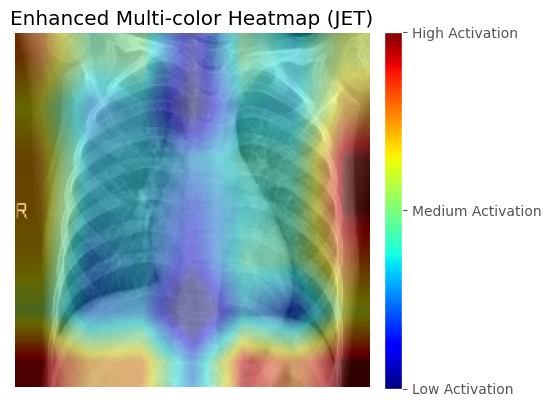

In [34]:
# Example usage:
img_path = 'chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0380-0001.jpeg'
final_heatmap_image = generate_and_merge_heatmaps(
    img_path,
    create_vgg19_model(),
    create_efficientnet_model(),
    create_densenet_model(),
    output_size=(224, 224)  # Specify the desired output size
)